### Лабораторная работа №5: Линейная регрессия
#### Выполнил студент группы 6131-010402D Кришталь Кирилл


In [141]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as pltx

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE, r2_score as R2
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

from warnings import filterwarnings
filterwarnings("ignore")

### 1. Считать в pandas.DataFrame любой источник данных: CSV, JSON, Excel-файл, HTML-таблицу и т.п

In [142]:
df_car = pd.read_csv("Car details v3.csv")

### 2. Датасет и подготовка данных
#### 2.1 Описание датасета

#### Этот набор данных содержит информацию о подержанных автомобилях. Эти данные могут быть использованы для многих целей, таких как прогнозирование цен.

| Признак | Описание | Тип данных |
|:-------:|:--------:|:----------:|
| name | Название машины | categorical |
| year | возраст машины с момента покупки | numeric |
| selling_price | Цена, по которой продается автомобиль | numeric |
| km_driven | Количество километров, пройденных автомобилем | numeric |
| fuel | Тип топлива автомобиля (бензин / дизель / СПГ / сжиженный газ / электричество) | categorical |
| seller_type | Указывает, является ли продавец частным лицом или дилером | categorical |  
| transmission | Коробка передач автомобиля (автоматическая/механическая) | categorical |
| Owner | Количество предыдущих владельцев автомобиля. | numeric |
| mileage | пробег | categorical |
| engine | объем двигателя автомобиля в см^3 | numeric |
| max_power | максимальная мощность двигателя автомобиля (л/с) | categorical |
| torque | крутящий момент (н/м) | numeric |
| seats | количество мест в автомобиле | numeric|




In [143]:
df_car.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [144]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


### 2.2 Предобработка данных 

In [145]:
df_car.isna().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
torque           222
seats            221
dtype: int64

In [146]:
# Удаление строк с NaN значениями в указанных столбцах
df_car.dropna(subset=['mileage', 'engine', 'max_power', 'torque', 'seats'], inplace=True)


In [147]:

df_car['mileage'] = df_car['mileage'].astype(str)
df_car['engine'] = df_car['engine'].astype(str)
df_car['max_power'] = df_car['max_power'].astype(str)
df_car['torque'] = df_car['torque'].astype(str)

df_car["mileage"] = df_car["mileage"].str.extract(r'(\d+\.\d+|\d+)').astype(float)
df_car["engine"] = df_car["engine"].str.extract(r'(\d+)').astype(int)
df_car["max_power"] = df_car["max_power"].str.extract(r'(\d+\.\d+|\d+)').astype(float)
df_car["torque"] = df_car["torque"].str.extract(r'(\d+\.\d+|\d+)').astype(float)

df_car.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190.0,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250.0,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497,78.00,12.7,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,22.4,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,11.5,5.0


In [148]:
# df = df_car.copy()

binary_features = ['name', 'fuel', 'seller_type', 'transmission','owner']
label_encode = LabelEncoder()
encoded_features = {}

for feature in binary_features:
    encoded_features[feature] = label_encode.fit_transform(df_car[feature])
    df_car[feature] = encoded_features[feature]

df_car.head()



,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,1249,2014,450000,145500,1,1,1,0,23.40,1248,74.00,190.0,5.0
1,1546,2014,370000,120000,1,1,1,2,21.14,1498,103.52,250.0,5.0
2,375,2006,158000,140000,3,1,1,4,17.70,1497,78.00,12.7,5.0
3,743,2010,225000,127000,1,1,1,0,23.00,1396,90.00,22.4,5.0
4,1290,2007,130000,120000,3,1,1,0,16.10,1298,88.20,11.5,5.0


Без категориальных признаков

In [149]:
df = df_car.copy()

cat_features = ['name', 'fuel', 'seller_type', 'transmission','owner']

df = df.drop(cat_features, axis = 1)



In [150]:
df.head()

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats
0,2014,450000,145500,23.40,1248,74.00,190.0,5.0
1,2014,370000,120000,21.14,1498,103.52,250.0,5.0
2,2006,158000,140000,17.70,1497,78.00,12.7,5.0
3,2010,225000,127000,23.00,1396,90.00,22.4,5.0
4,2007,130000,120000,16.10,1298,88.20,11.5,5.0


### 2.3 Нормализация данных

In [151]:
X = df.drop("selling_price", axis = 1)
y = df["selling_price"]

scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled, columns = X.columns)
y_scaled = scaler.fit_transform(y.values.reshape(-1,1)).flatten()


### 2.4 Визуализировать heatmap

<Axes: >

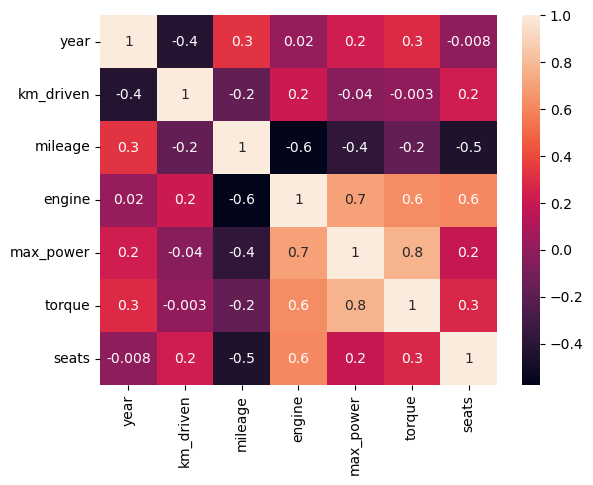

In [152]:
df_matrix = scaled_df.corr()
sns.heatmap(df_matrix, annot= True, fmt='.1g') 

### 2.5 Визуализировать взаимосвязь между target-переменной и каждым из признаком

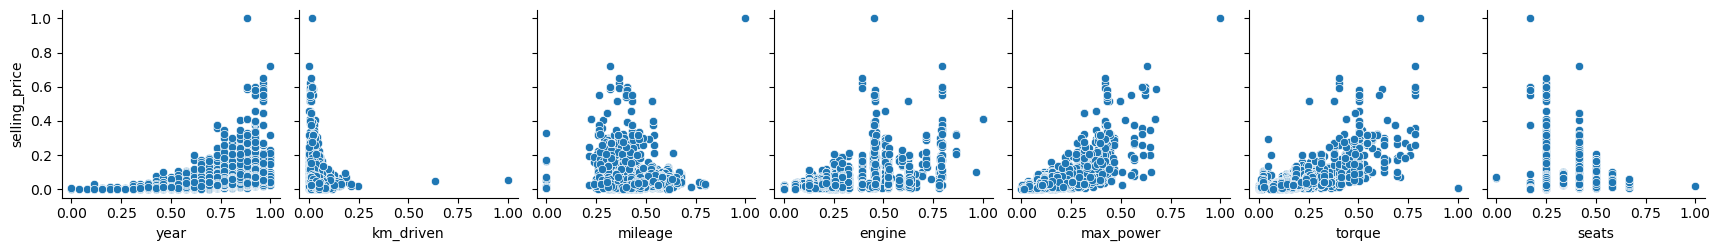

In [154]:

scaled_df['selling_price'] = y_scaled

# Построение pairplot
sns.pairplot(scaled_df, y_vars=["selling_price"], x_vars= X.columns, height=2.5)
plt.show()


### 2.6 Разделение выборки на обучающую и тестовую

In [155]:
x_trains, x_tests, y_trains, y_tests = train_test_split(scaled_car_df, y_car_scaled, test_size= 0.3, random_state= 42)

### 3. Регрессия МНК
#### 3.1 Обучить модель линейной регрессии (LinearRegression)

In [156]:
model_lr = LinearRegression()
model_lr.fit(x_train, y_train)
model_lr_pred_train = model_lr.predict(x_train)
model_lr_pred_test = model_lr.predict(x_test)

### 3.2 Вывести метрики MAE, MSE и R^2 на обущающем и тестовом наборе.

In [157]:
print(f"Средняя квадратичная ошибка (MSE): {MSE(y_test, model_lr_pred_test):.3f}")
print(f"Средняя абсолютная ошибка (MAE): {MAE(y_test, model_lr_pred_test):.3f}")
print(f"Коэффициент детерминации (R2 score): {R2(y_test, model_lr_pred_test):.3f}")

Средняя квадратичная ошибка (MSE): 0.002
Средняя абсолютная ошибка (MAE): 0.029
Коэффициент детерминации (R2 score): 0.639


### 3.3 Вывести model.coef_ и model.intercept_

In [158]:
model_lr.coef_

array([ 0.09820059, -0.44052537,  0.03717796,  0.03406298,  0.53505991,
        0.03248488, -0.0879548 ])

In [159]:
model_lr.intercept_

-0.09466077417368263

### 3.4 Построить график (barh) с важностью коэфициентов при соответствующих признаках.

([<matplotlib.axis.YTick at 0x216d631aa50>,
 [Text(0, 0, 'km_driven'),
  Text(0, 1, 'seats'),
  Text(0, 2, 'torque'),
  Text(0, 3, 'engine'),
  Text(0, 4, 'mileage'),
  Text(0, 5, 'year'),
  Text(0, 6, 'max_power')])

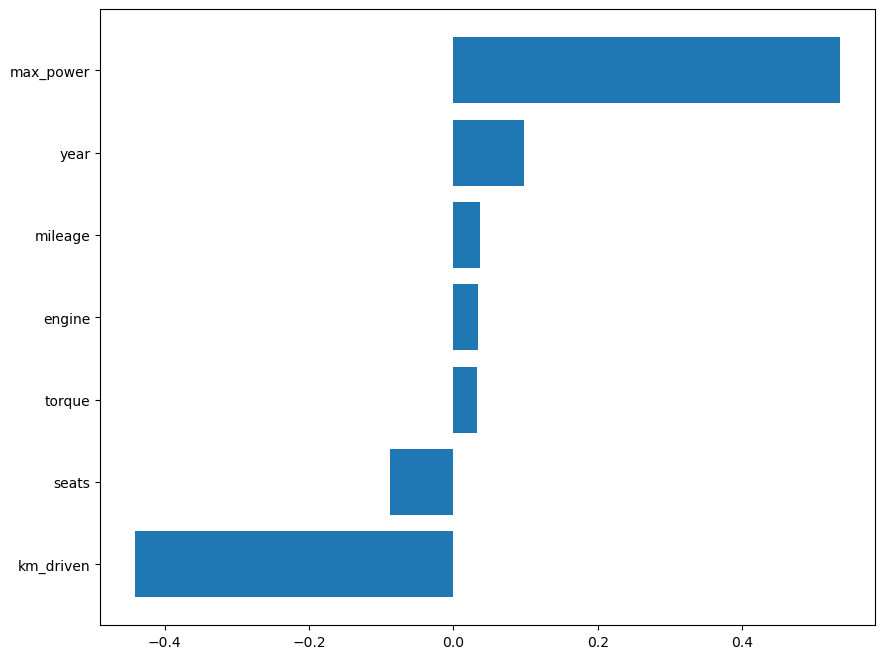

In [160]:
coefs = []
names = []
z = zip(model_lr.coef_, X.columns)
z = sorted(z, key=lambda x: x[0])
for c, n in z:
    coefs.append(c)
    names.append(n)

plt.figure(figsize=(10,8))
plt.barh(range(len(model_lr.coef_)), coefs, align='center')
plt.yticks(range(len(model_lr.coef_)), names)

### 4. Для каждого вида регрессии (`Ridge`, `LASSO`, `Elastic Net`):
   - С использованием `GridSearchCV` осуществить подбор параметров регуляризации (`alpha` для `Ridge` и `LASSO`, `alpha` и `l1_ratio` для `Elastic Net`)
   - Вывести значения гиперпараметров, коэффициенты регрессии (`model.coef_` и `model.intercept_`) и значения метрик на тестовом наборе для наилучшей модели ($MSE$, $MAE$ и $R^2$).
   - Построить график (`barh`) с важностью коэфициентов при соответствующих признаках (сверху вниз расположены коэффициенты по убыванию, а названия соответствующих признаков подписаны по вертикальной оси).  
   
   > Запомнить лучшие модели для 2 этапа.

   - С использованием `GridSearchCV` осуществить подбор параметров регуляризации (`alpha` для `Ridge` и `LASSO`, `alpha` и `l1_ratio` для `Elastic Net`)

In [161]:
grid_ridge_lasso = {'alpha': np.arange(0.1, 5, 0.1)}

ridge = Ridge()
search_ridge = GridSearchCV(ridge, grid_ridge_lasso, cv = 5, n_jobs= -1, verbose= 2)
search_ridge.fit(x_train, y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9])},
             verbose=2)

In [162]:
lasso = Lasso()
search_lasso = GridSearchCV(lasso, grid_ridge_lasso, cv = 5,  n_jobs= -1, verbose= 2)
search_lasso.fit(x_train, y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9])},
             verbose=2)

In [163]:
grid_elastic_net = {'alpha': np.arange(0.1, 5, 0.1), 'l1_ratio': [0.25, 0.5, 0.75]}

elastic_net = ElasticNet()
search_elastic_net = GridSearchCV(elastic_net, grid_elastic_net, cv = 5,  n_jobs= -1, verbose= 2)
search_elastic_net.fit(x_train, y_train)

Fitting 5 folds for each of 147 candidates, totalling 735 fits


GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9]),
                         'l1_ratio': [0.25, 0.5, 0.75]},
             verbose=2)

   - Вывести значения гиперпараметров, коэффициенты регрессии (`model.coef_` и `model.intercept_`) и значения метрик на тестовом наборе для наилучшей модели ($MSE$, $MAE$ и $R^2$).

In [164]:
print(f'best ridge:\t{search_ridge.best_params_}')
print(f'best lasso:\t{search_lasso.best_params_}')
print(f'best elastic net:\t{search_elastic_net.best_params_}')

best ridge:	{'alpha': 0.2}
best lasso:	{'alpha': 0.1}
best elastic net:	{'alpha': 0.1, 'l1_ratio': 0.25}


In [165]:
best_ridge = search_ridge.best_estimator_
best_lasso = search_lasso.best_estimator_
best_elastic_net = search_elastic_net.best_estimator_

In [185]:
print('---------RIDGE---------')
print(f'model.coef_:\t{best_ridge.coef_}')
print(f'model.inteercept_:\t{best_ridge.intercept_}')
print('---------LASSO---------')
print(f'model.coef_:\t{best_lasso.coef_}')
print(f'model.inteercept_:\t{best_lasso.intercept_}')
print('---------ELASTIC NET---------')
print(f'model.coef_:\t{best_elastic_net.coef_}')
print(f'model.inteercept_:\t{best_elastic_net.intercept_}')


# Создание и обучение модели Lasso
lasso = LassoCV(cv=5)
lasso.fit(X, y)

print("Lasso coefficients:", lasso.coef_)
print("Lasso intercept:", lasso.intercept_)


---------RIDGE---------
model.coef_:	[ 0.10161461 -0.40027362  0.03400617  0.03387743  0.52940867  0.03503934
 -0.09158162]
model.inteercept_:	-0.09553786328752786
---------LASSO---------
model.coef_:	[ 0. -0. -0.  0.  0.  0.  0.]
model.inteercept_:	0.06241862378924515
---------ELASTIC NET---------
model.coef_:	[ 0. -0. -0.  0.  0.  0.  0.]
model.inteercept_:	0.06241862378924515
Lasso coefficients: [   0.           -4.0502132     0.          484.14076497    0.
 2513.42160561   -0.        ]
Lasso intercept: -199171.9947948967


In [186]:
print('---------RIDGE---------')
y_pred_ridge = best_ridge.predict(x_test)
print(f"Средняя квадратичная ошибка (MSE): {MSE(y_test, y_pred_ridge):.3f}")
print(f"Средняя абсолютная ошибка (MAE): {MAE(y_test, y_pred_ridge):.3f}")
print(f"Коэффициент детерминации (R2 score): {R2(y_test, y_pred_ridge):.3f}")

print('---------LASSO---------')
y_pred_lasso = best_lasso.predict(x_test)
print(f"Средняя квадратичная ошибка (MSE): {MSE(y_test, y_pred_lasso):.3f}")
print(f"Средняя абсолютная ошибка (MAE): {MAE(y_test, y_pred_lasso):.3f}")
print(f"Коэффициент детерминации (R2 score): {R2(y_test, y_pred_lasso):.3f}")

print('---------ELASTIC NET---------')
y_pred_el_net = best_elastic_net.predict(x_test)
print(f"Средняя квадратичная ошибка (MSE): {MSE(y_test, y_pred_el_net):.3f}")
print(f"Средняя абсолютная ошибка (MAE): {MAE(y_test, y_pred_el_net):.3f}")
print(f"Коэффициент детерминации (R2 score): {R2(y_test, y_pred_el_net):.3f}")

---------RIDGE---------
Средняя квадратичная ошибка (MSE): 0.002
Средняя абсолютная ошибка (MAE): 0.028
Коэффициент детерминации (R2 score): 0.640
---------LASSO---------
Средняя квадратичная ошибка (MSE): 0.007
Средняя абсолютная ошибка (MAE): 0.043
Коэффициент детерминации (R2 score): -0.000
---------ELASTIC NET---------
Средняя квадратичная ошибка (MSE): 0.007
Средняя абсолютная ошибка (MAE): 0.043
Коэффициент детерминации (R2 score): -0.000


   - Построить график (`barh`) с важностью коэфициентов при соответствующих признаках (сверху вниз расположены коэффициенты по убыванию, а названия соответствующих признаков подписаны по вертикальной оси).  
   
   > Запомнить лучшие модели для 2 этапа.

([<matplotlib.axis.YTick at 0x216d6c9cf10>,
 [Text(0, 0, 'km_driven'),
  Text(0, 1, 'seats'),
  Text(0, 2, 'engine'),
  Text(0, 3, 'mileage'),
  Text(0, 4, 'torque'),
  Text(0, 5, 'year'),
  Text(0, 6, 'max_power')])

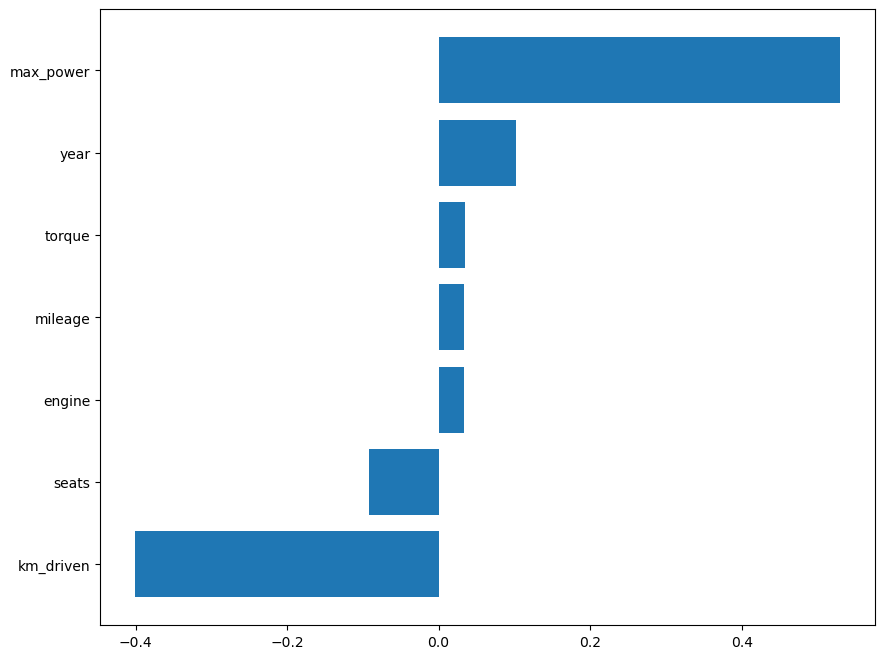

In [187]:
coefs_ridge = []
names_ridge = []
z_ridge = zip(best_ridge.coef_, X.columns)
z_ridge = sorted(z_ridge, key=lambda x: x[0])
for c, n in z_ridge:
    coefs_ridge.append(c)
    names_ridge.append(n)

plt.figure(figsize=(10,8))
plt.barh(range(len(best_ridge.coef_)), coefs_ridge, align='center')
plt.yticks(range(len(best_ridge.coef_)), names_ridge)


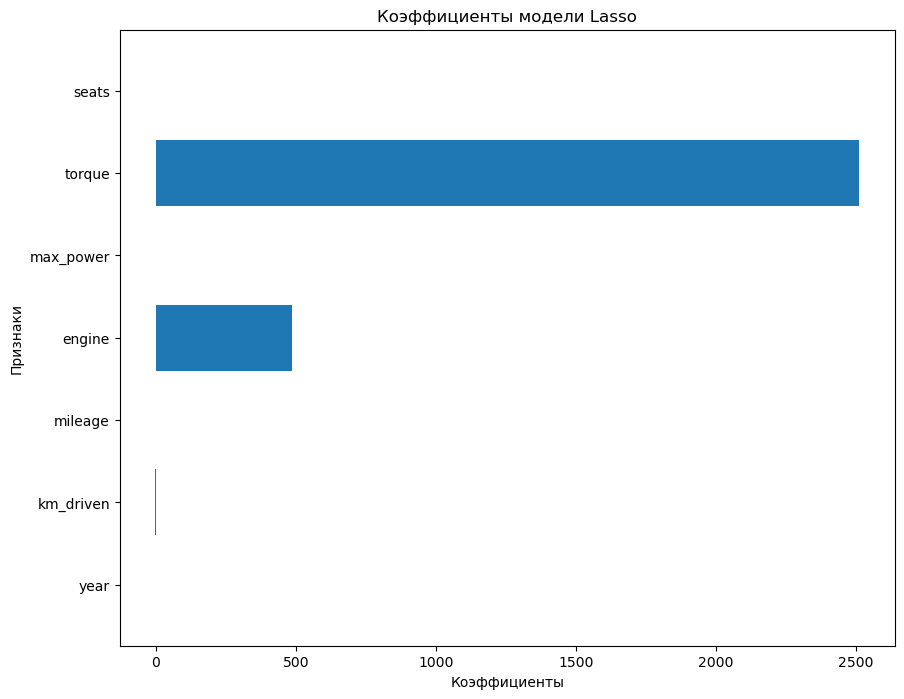

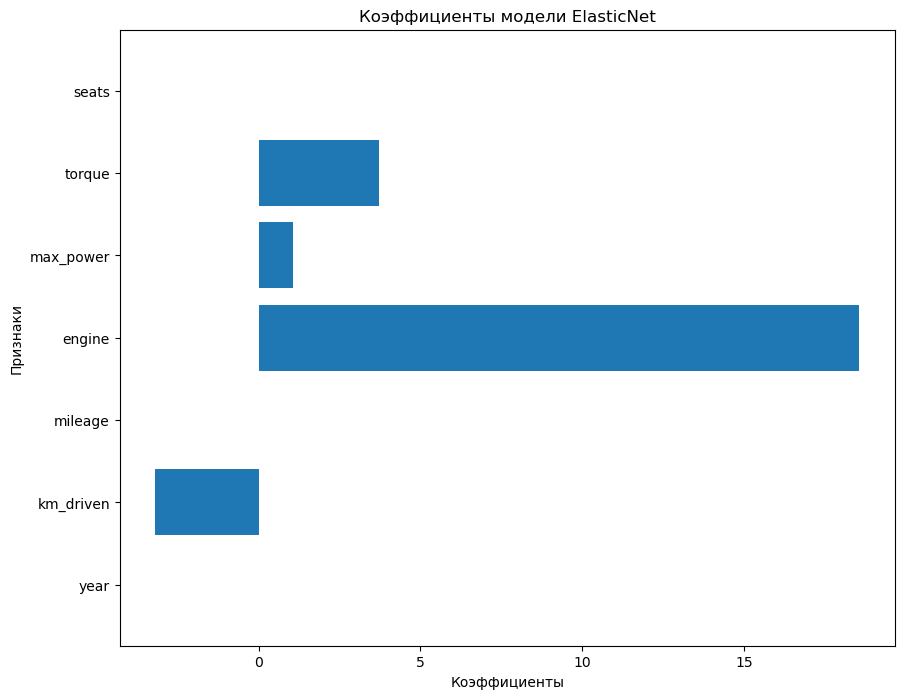

In [188]:
import matplotlib.pyplot as plt

# Для Lasso
coefs_lasso = lasso.coef_
names_lasso = X.columns

plt.figure(figsize=(10, 8))
plt.barh(range(len(coefs_lasso)), coefs_lasso, align='center')
plt.yticks(range(len(coefs_lasso)), names_lasso)
plt.xlabel('Коэффициенты')
plt.ylabel('Признаки')
plt.title('Коэффициенты модели Lasso')
plt.show()

# Для ElasticNet
coefs_el_net = elastic_net.coef_
names_el_net = X.columns

plt.figure(figsize=(10, 8))
plt.barh(range(len(coefs_el_net)), coefs_el_net, align='center')
plt.yticks(range(len(coefs_el_net)), names_el_net)
plt.xlabel('Коэффициенты')
plt.ylabel('Признаки')
plt.title('Коэффициенты модели ElasticNet')
plt.show()


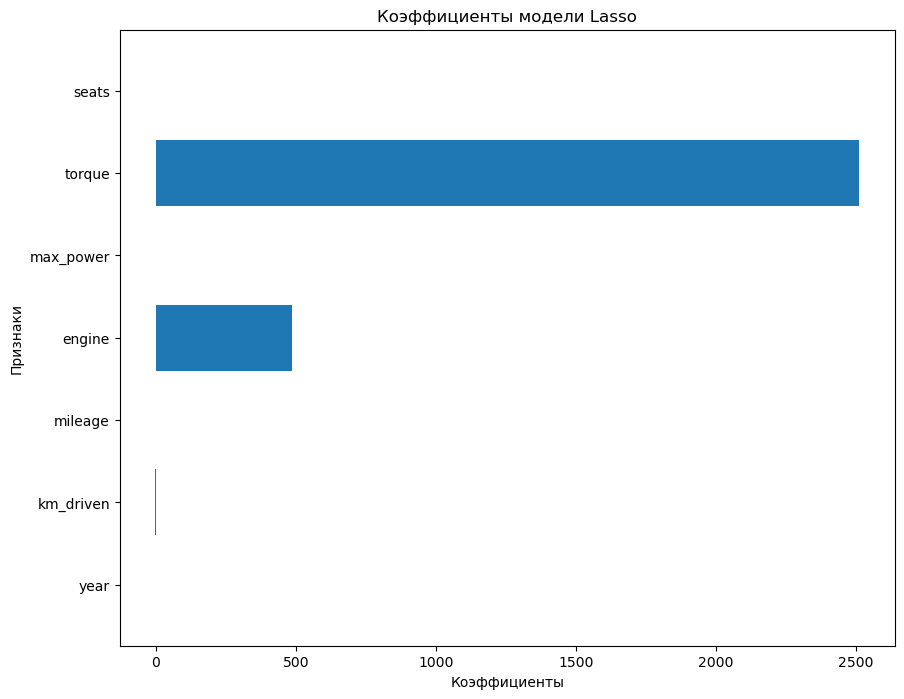

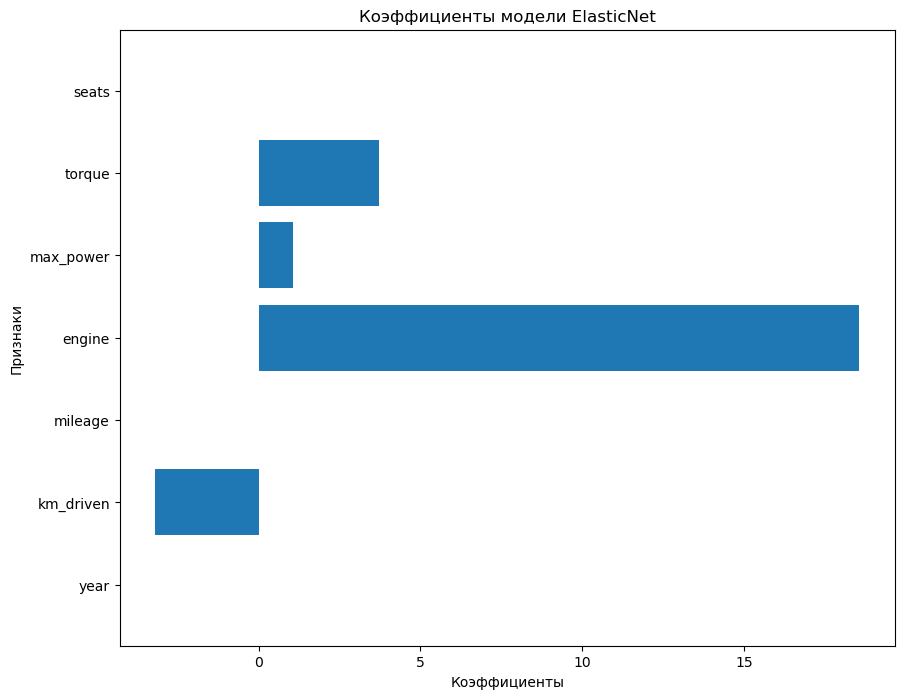

In [190]:
import matplotlib.pyplot as plt

# Для Lasso
coefs_lasso = lasso.coef_
names_lasso = X.columns

plt.figure(figsize=(10, 8))
plt.barh(range(len(coefs_lasso)), coefs_lasso, align='center')
plt.yticks(range(len(coefs_lasso)), names_lasso)
plt.xlabel('Коэффициенты')
plt.ylabel('Признаки')
plt.title('Коэффициенты модели Lasso')
plt.show()

# Для ElasticNet
coefs_el_net = elastic_net.coef_
names_el_net = X.columns

plt.figure(figsize=(10, 8))
plt.barh(range(len(coefs_el_net)), coefs_el_net, align='center')
plt.yticks(range(len(coefs_el_net)), names_el_net)
plt.xlabel('Коэффициенты')
plt.ylabel('Признаки')
plt.title('Коэффициенты модели ElasticNet')
plt.show()


5. Датасет и подготовка данных, этап 2:
   - Использовать датафреймы после разбиения на обучающую и тестовую выборки из 1 этапа с категориальными признаками.
   - Закодировать категориальные признаки в обучающей и тестовой выборках.

In [191]:
df_car.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,1249,2014,450000,145500,1,1,1,0,23.40,1248,74.00,190.0,5.0
1,1546,2014,370000,120000,1,1,1,2,21.14,1498,103.52,250.0,5.0
2,375,2006,158000,140000,3,1,1,4,17.70,1497,78.00,12.7,5.0
3,743,2010,225000,127000,1,1,1,0,23.00,1396,90.00,22.4,5.0
4,1290,2007,130000,120000,3,1,1,0,16.10,1298,88.20,11.5,5.0


In [192]:
x_car = df_car.drop("selling_price", axis = 1)
y_car = df_car["selling_price"]

scaler_car = MinMaxScaler()
scaled_car = scaler_car.fit_transform(x_car)
scaled_car_df = pd.DataFrame(scaled_car, columns = x_car.columns)
y_car_scaled = scaler_car.fit_transform(y_car.values.reshape(-1,1)).flatten()

In [193]:
x_trains, x_tests, y_trains, y_tests = train_test_split(x_car,y_car_scaled, test_size= 0.3, random_state= 42)

### 6. Регрессии, этап 2:

### 6.1 Обучить LinearRegression, лучшие модели Ridge, LASSO, Elastic Net на обучающем наборе с категориальными признаками. 

In [194]:
linear_model_cat = LinearRegression()
linear_model_cat.fit(x_trains, y_trains)

best_ridge.fit(x_trains, y_trains)
best_lasso.fit(x_trains, y_trains)
best_elastic_net.fit(x_trains, y_trains)

ElasticNet(alpha=0.1, l1_ratio=0.25)

   - Вывести значения гиперпараметров, коэффициенты регрессии (`model.coef_` и `model.intercept_`) и значения метрик на тестовом наборе ($MSE$, $MAE$ и $R^2$).
   

In [195]:
print('---------LINEAR REGRESSION---------')
y_pred_lr = linear_model_cat.predict(x_tests)
print(f"Средняя квадратичная ошибка (MSE): {MSE(y_tests, y_pred_lr):.3f}")
print(f"Средняя абсолютная ошибка (MAE): {MAE(y_tests, y_pred_lr):.3f}")
print(f"Коэффициент детерминации (R2 score): {R2(y_tests, y_pred_lr):.3f}")
print(f"model.coef_:\t{linear_model_cat.coef_}")
print(f"model.intercept_:\t{linear_model_cat.intercept_}")

print('---------RIDGE---------')
y_pred_ridge_car = best_ridge.predict(x_tests)
print(f"Средняя квадратичная ошибка (MSE): {MSE(y_tests, y_pred_ridge_car):.3f}")
print(f"Средняя абсолютная ошибка (MAE): {MAE(y_tests, y_pred_ridge_car):.3f}")
print(f"Коэффициент детерминации (R2 score): {R2(y_tests, y_pred_ridge_car):.3f}")
print(f"model.coef_:\t{best_ridge.coef_}")
print(f"model.intercept_:\t{best_ridge.intercept_}")

print('---------LASSO---------')
y_pred_lasso_car = best_lasso.predict(x_tests)
print(f"Средняя квадратичная ошибка (MSE): {MSE(y_tests, y_pred_lasso_car):.3f}")
print(f"Средняя абсолютная ошибка (MAE): {MAE(y_tests, y_pred_lasso_car):.3f}")
print(f"Коэффициент детерминации (R2 score): {R2(y_tests, y_pred_lasso_car):.3f}")
print(f"model.coef_:\t{best_lasso.coef_}")
print(f"model.intercept_:\t{best_lasso.intercept_}")

print('---------ELASTIC NET---------')
y_pred_el_net_car = best_elastic_net.predict(x_tests)
print(f"Средняя квадратичная ошибка (MSE): {MSE(y_tests, y_pred_el_net_car):.3f}")
print(f"Средняя абсолютная ошибка (MAE): {MAE(y_tests, y_pred_el_net_car):.3f}")
print(f"Коэффициент детерминации (R2 score): {R2(y_tests, y_pred_el_net_car):.3f}")
print(f"model.coef_:\t{best_elastic_net.coef_}")
print(f"model.intercept_:\t{best_elastic_net.intercept_}")

---------LINEAR REGRESSION---------
Средняя квадратичная ошибка (MSE): 0.002
Средняя абсолютная ошибка (MAE): 0.027
Коэффициент детерминации (R2 score): 0.685
model.coef_:	[-1.93839453e-06  3.14552805e-03 -1.39328552e-07 -1.48484370e-03
 -1.98236854e-02 -4.57884287e-02 -1.40876547e-03  1.21163359e-03
  1.13431944e-05  1.20312929e-03  2.45447495e-05 -3.66501728e-03]
model.intercept_:	-6.334640842402902
---------RIDGE---------
Средняя квадратичная ошибка (MSE): 0.002
Средняя абсолютная ошибка (MAE): 0.027
Коэффициент детерминации (R2 score): 0.685
model.coef_:	[-1.93813112e-06  3.14568808e-03 -1.39344029e-07 -1.48350900e-03
 -1.98204734e-02 -4.57660268e-02 -1.40891211e-03  1.21153043e-03
  1.13439870e-05  1.20323489e-03  2.45528069e-05 -3.66632948e-03]
model.intercept_:	-6.334990101508139
---------LASSO---------
Средняя квадратичная ошибка (MSE): 0.003
Средняя абсолютная ошибка (MAE): 0.028
Коэффициент детерминации (R2 score): 0.588
model.coef_:	[-2.13356140e-06  0.00000000e+00 -3.382750

   - Сравнить метрики с наличием категориальных признаков и без для каждой из моделей.

Для всех моделей добавление категориальных переменных позволило улучшить все метрики (уменьшить ошибку и увеличить $R^2$)

   - Выбрать лучшую модель.

In [196]:
best_model = linear_model_cat

   - Построить график (`barh`) с важностью коэфициентов при соответствующих признаках (сверху вниз расположены коэффициенты по убыванию, а названия соответствующих признаков подписаны по вертикальной оси).

([<matplotlib.axis.YTick at 0x216d6871b50>,
 [Text(0, 0, 'transmission'),
  Text(0, 1, 'seller_type'),
  Text(0, 2, 'seats'),
  Text(0, 3, 'fuel'),
  Text(0, 4, 'owner'),
  Text(0, 5, 'name'),
  Text(0, 6, 'km_driven'),
  Text(0, 7, 'engine'),
  Text(0, 8, 'torque'),
  Text(0, 9, 'max_power'),
  Text(0, 10, 'mileage'),
  Text(0, 11, 'year')])

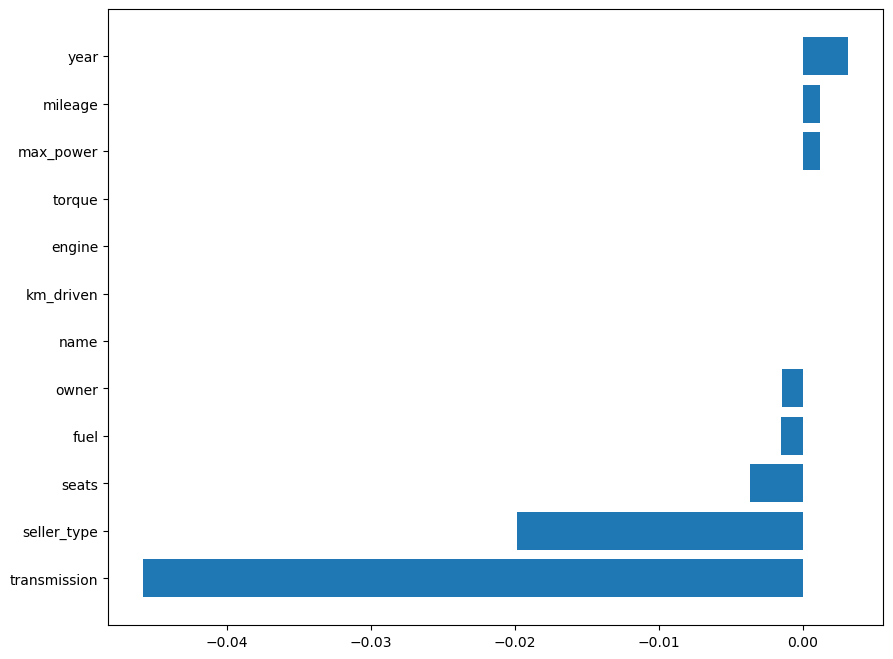

In [197]:
coefs_best = []
names_best = []
z_best = zip(best_model.coef_, x_car.columns)
z_best = sorted(z_best, key=lambda x: x[0])
for c, n in z_best:
    coefs_best.append(c)
    names_best.append(n)

plt.figure(figsize=(10,8))
plt.barh(range(len(best_model.coef_)), coefs_best, align='center')
plt.yticks(range(len(best_model.coef_)), names_best)


### 6.6 Осуществить фильтрацию признаков с использованием Recursive Feature Elimination.

In [198]:
rfe = RFE(estimator=LinearRegression(), n_features_to_select=5)
# model_rfe = LinearRegression()
rfe.fit(x_trains,y_trains)



RFE(estimator=LinearRegression(), n_features_to_select=5)

### 6.7 Построить график (barh) с важностью коэфициентов при соответствующих признаках (сверху вниз расположены коэффициенты по убыванию, а названия соответствующих признаков подписаны по вертикальной оси).

([<matplotlib.axis.YTick at 0x216d6777a10>,
 [Text(0, 0, 'fuel'),
  Text(0, 1, 'km_driven'),
  Text(0, 2, 'year'),
  Text(0, 3, 'seller_type'),
  Text(0, 4, 'name')])

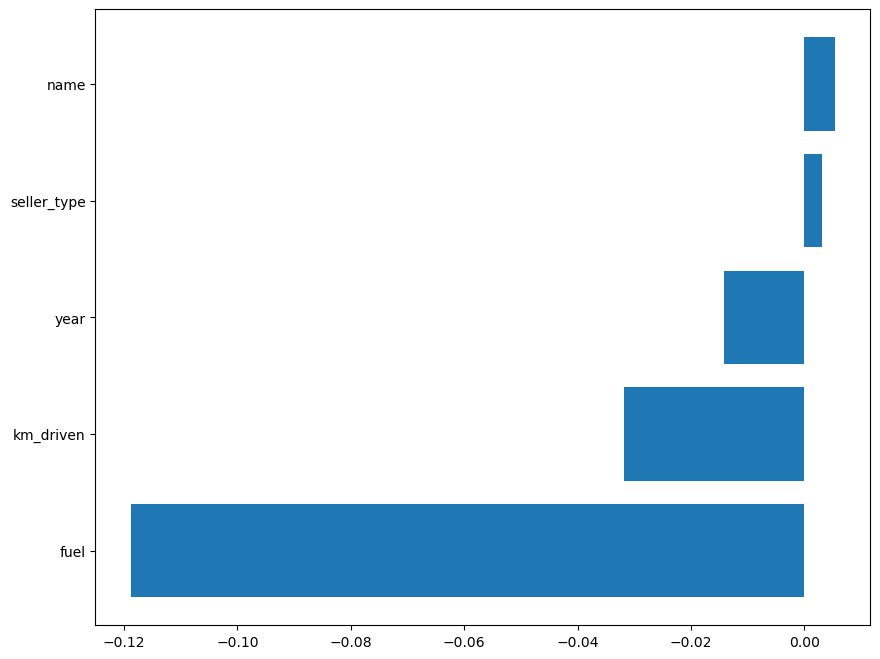

In [199]:
coefs_rfe = []
names_rfe = []
# Getting the coefficients from the estimator used by RFE
estimator_coefs = rfe.estimator_.coef_
zz_rfe = zip(estimator_coefs, x_tests.columns)
zz_rfe = sorted(zz_rfe, key=lambda x: x[0])
for c, n in zz_rfe:
    coefs_rfe.append(c)
    names_rfe.append(n)

plt.figure(figsize=(10,8))
plt.barh(range(len(estimator_coefs)), coefs_rfe, align='center')
plt.yticks(range(len(estimator_coefs)), names_rfe)


   - Вывести значения метрик на тестовом наборе ($MSE$, $MAE$ и $R^2$).

In [200]:
y_pred_rfe = rfe.predict(x_tests)

print(f"Средняя квадратичная ошибка (MSE):\t{MSE(y_tests, y_pred_rfe):.3f}")
print(f"Средняя абсолютная ошибка (MAE):\t{MAE(y_tests, y_pred_rfe):.3f}")
print(f"Коэффициент детерминации (R2 score):\t{R2(y_tests, y_pred_rfe):.3f}")

Средняя квадратичная ошибка (MSE):	0.003
Средняя абсолютная ошибка (MAE):	0.031
Коэффициент детерминации (R2 score):	0.506


### 7. Вывод:

#### 7.1 Лучший регрессор без категориальных признаков - Ridge
#### 7.2 Лучший регрессор с категориальными признаками - Линейная регрессия

### 7.3 все метрики стали хуже 